In [1]:
import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def step_to_block(step, block_size=32, block_id_base=1):
    block_idx0 = step // block_size
    step_block = step % block_size
    block_id = block_idx0 + block_id_base
    return block_id, step_block

def load_kv_tensor(path):
    obj = torch.load(path, map_location="cpu")
    if torch.is_tensor(obj):
        return obj
    if isinstance(obj, dict):
        for key in ["k", "v", "key", "value", "K", "V"]:
            if key in obj and torch.is_tensor(obj[key]):
                return obj[key]
    raise TypeError(f"Unrecognized content in {path}: {type(obj)}")

def load_step_layer_tensor(records_dir, sample_id, layer, kind, step,
                           block_size=32, block_id_base=1):
    block_id, step_block = step_to_block(step, block_size, block_id_base)
    fname = f"batch_{sample_id}_{block_id}_{step_block}_{layer}_{kind}_previous.pt"
    fpath = os.path.join(records_dir, fname)
    if not os.path.exists(fpath):
        raise FileNotFoundError(f"Missing file: {fpath}")
    T = load_kv_tensor(fpath)

    # allow [1, seq, hidden]
    if T.ndim == 3 and T.shape[0] == 1:
        T = T[0]

    # expect [seq, hidden]
    if T.ndim != 2:
        raise ValueError(f"Expected [seq, hidden], got {tuple(T.shape)} in {fpath}")

    return T.detach().float()  # float32 cpu

def delta_layer_sim_for_step(
    records_dir,
    sample_id: int,
    token_pos: int,
    step: int,                 # compares step vs step-1
    kind: str = "k",
    layer_start: int = 24,
    layer_end: int = 31,
    total_steps: int = 128,
    block_size: int = 32,
    block_id_base: int = 1,
):
    if step <= 0 or step >= total_steps:
        raise ValueError(f"step must be in [1, {total_steps-1}], got {step}")

    layers = list(range(layer_start, layer_end + 1))
    deltas = []

    for layer in layers:
        cur = load_step_layer_tensor(records_dir, sample_id, layer, kind, step,
                                     block_size=block_size, block_id_base=block_id_base)
        prev = load_step_layer_tensor(records_dir, sample_id, layer, kind, step - 1,
                                      block_size=block_size, block_id_base=block_id_base)

        d = cur[token_pos] - prev[token_pos]   # [hidden]
        deltas.append(d)

    X = torch.stack(deltas, dim=0)             # [L, hidden]
    Xn = F.normalize(X, dim=1, eps=1e-8)
    S = Xn @ Xn.T                              # [L, L]
    return S, layers

def delta_layer_sim_mean_over_steps(
    records_dir,
    sample_id: int,
    token_pos: int,
    kind: str = "k",
    layer_start: int = 24,
    layer_end: int = 31,
    steps: list | None = None,     # list of step indices n where compare n vs n-1
    total_steps: int = 128,
    block_size: int = 32,
    block_id_base: int = 1,
):
    layers = list(range(layer_start, layer_end + 1))
    L = len(layers)

    if steps is None:
        steps = list(range(1, total_steps))   # 1..127

    sims = torch.empty((len(steps), L, L), dtype=torch.float32)

    for i, step in enumerate(steps):
        S, _ = delta_layer_sim_for_step(
            records_dir=records_dir,
            sample_id=sample_id,
            token_pos=token_pos,
            step=step,
            kind=kind,
            layer_start=layer_start,
            layer_end=layer_end,
            total_steps=total_steps,
            block_size=block_size,
            block_id_base=block_id_base,
        )
        sims[i] = S

    S_mean = sims.mean(dim=0)  # [L, L]
    return S_mean, layers, sims  # sims is per-step if you want more plots later

def plot_layer_heatmap(S, layers, title="", savepath=None, vmin=-1.0, vmax=1.0):
    plt.figure(figsize=(6, 5), dpi=150)
    im = plt.imshow(S.numpy(), cmap="RdYlGn", vmin=vmin, vmax=vmax)
    plt.colorbar(im, fraction=0.046, pad=0.04, label="cosine similarity")
    plt.xticks(range(len(layers)), layers, rotation=45)
    plt.yticks(range(len(layers)), layers)
    plt.xlabel("layer")
    plt.ylabel("layer")
    plt.title(title)
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath)
    plt.show()


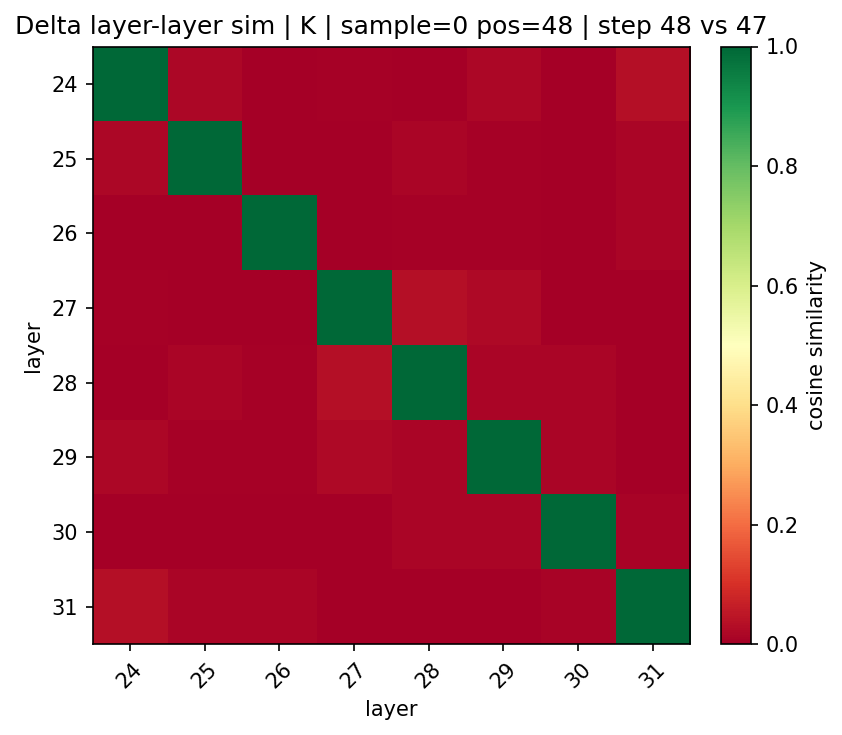

In [3]:
records_dir = "kv_states"
sample_id = 0
token_pos = 48
kind = "k"
step = 48

S, layers = delta_layer_sim_for_step(
    records_dir, sample_id, token_pos, step,
    kind=kind, layer_start=24, layer_end=31,
    block_id_base=0,
)

plot_layer_heatmap(
    S, layers,
    title=f"Delta layer-layer sim | {kind.upper()} | sample={sample_id} pos={token_pos} | step {step} vs {step-1}",
    savepath=f"delta_layer_sim_{kind}_b{sample_id}_p{token_pos}_s{step}.png",
    vmin=0.0
)
